In [60]:
# dependencies
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import re
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics
# from sklearn.feature_extraction.text import CountVectorizer
# import seaborn as sns
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# import string
# import lime
# from lime import lime_text

# only need to run once
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

# declarations
# stop = stopwords.words('english')

In [80]:
# read in CSV
all_wines = pd.read_csv('Data/winemag-data-130k-v2.csv')
all_wines.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [110]:
# add vintage year based on year in title
all_wines['vintage'] = all_wines['title'].str.extract('(\d\d\d\d)', expand=True)

# filling in known variety for nulls
all_wines.iloc[86909, 7] = 'Syrah-Petite Sirah'

# drop unneeded columns
clean_wines = all_wines.drop(columns=['Unnamed: 0', 'description', 'designation', 'region_1', 'region_2', 'title', \
                                      'taster_name', 'taster_twitter_handle'])

# filling in known country for nulls
has_country = clean_wines[pd.notnull(clean_wines['country'])]
has_country_series = pd.Series(data=has_country['country'].values, index=has_country['winery'])
has_country_dict = has_country_series.to_dict()
clean_wines.loc[clean_wines['country'].isnull(), 'country'] \
    = clean_wines['country'].fillna(clean_wines['winery'].map(has_country_dict))

# drop the remaining nulls
clean_wines = clean_wines.dropna()

# replace variety names with common wine names
clean_wines['variety'] = clean_wines['variety'].replace(['Weissburgunder'], 'Chardonnay')
clean_wines['variety'] = clean_wines['variety'].replace(['Spatburgunder'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Grauburgunder'], 'Pinot Gris')
clean_wines['variety'] = clean_wines['variety'].replace(['Garnacha'], 'Grenache')
clean_wines['variety'] = clean_wines['variety'].replace(['Pinot Nero'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Alvarinho'], 'Albarino')

# add age based on year
clean_wines['age'] = 2020 - clean_wines['vintage'].astype(int)

# add price_age_ratio
clean_wines['price_age_ratio'] = clean_wines['price'] / clean_wines['age']

# add rating
clean_wines['grade'] = clean_wines['points'].apply(lambda x: 'Great' if x >= 90 else
                                                             'OK' if x >= 75 else 'Bad')

#
country_great = clean_wines.loc[clean_wines['grade'] == 'Great']['country'].value_counts().reset_index(name='great_grade')
country_ok = clean_wines.loc[clean_wines['grade'] == 'OK']['country'].value_counts().reset_index(name='ok_grade') 
country_bad = clean_wines.loc[clean_wines['grade'] == 'Bad']['country'].value_counts().reset_index(name='bad_grade')
grade_list = [country_great, country_ok, country_bad]

from functools import reduce
country_grade = reduce(lambda left, right: pd.merge(left, right, on = 'index'), grade_list)
country_grade

# ok = clean_wines.loc[clean_wines['grade'] == 'OK']
# bad = clean_wines.loc[clean_wines['grade'] == 'Bad']

# clean_wines
# final clean dataframe
# clean_wines

,index,great_grade,ok_grade,bad_grade


In [20]:
# get upper quantile
clean_wines.quantile(q=0.75, axis=0, numeric_only=True)

points             91.0
price              42.0
age                11.0
price_age_ratio     5.0
Name: 0.75, dtype: float64

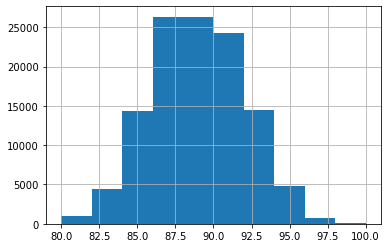

In [21]:
# plot histogram
clean_wines['points'].hist()

In [6]:
# add price_points_ratio
# clean_wines['price_points_ratio'] = clean_wines['price'] / clean_wines['points']
# clean_wines.head()

In [7]:
from sklearn.preprocessing import LabelEncoder

number = LabelEncoder()
features = clean_wines[['country','price','province','winery','age','price_age_ratio']]
features['country'] = number.fit_transform(features['country'].astype('str'))
features['province'] = number.fit_transform(features['province'].astype('str'))
features['winery'] = number.fit_transform(features['winery'].astype('str'))

features

C:\Users\Rahil\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Rahil\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Rahil\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

,country,price,province,winery,age,price_age_ratio
1,30,15.0,106,11884,9,1.666667
2,39,14.0,261,11943,7,2.000000
3,39,13.0,212,13231,7,1.857143
4,39,65.0,261,13451,8,8.125000
5,36,15.0,255,13530,9,1.666667
...,...,...,...,...,...,...
129966,16,28.0,226,5991,7,4.000000
129967,39,75.0,261,4314,16,4.687500
129968,14,30.0,11,5364,7,4.285714
129969,14,32.0,11,5449,8,4.000000


In [8]:
X = features
y = clean_wines['grade']

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=6))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1400      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 42,002
Trainable params: 42,002
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
2737/2737 - 4s - loss: 0.5396 - accuracy: 0.7286
Epoch 2/100
2737/2737 - 3s - loss: 0.5063 - accuracy: 0.7506
Epoch 3/100
2737/2737 - 4s - loss: 0.5041 - accuracy: 0.7516
Epoch 4/100
2737/2737 - 4s - loss: 0.5034 - accuracy: 0.7525
Epoch 5/100
2737/2737 - 5s - loss: 0.5000 - accuracy: 0.7546
Epoch 6/100
2737/2737 - 4s - loss: 0.4990 - accuracy: 0.7554
Epoch 7/100
2737/2737 - 3s - loss: 0.4975 - accuracy: 0.7551
Epoch 8/100
2737/2737 - 4s - loss: 0.4973 - accuracy: 0.7559
Epoch 9/100
2737/2737 - 5s - loss: 0.4971 - accuracy: 0.7558
Epoch 10/100
2737/2737 - 4s - loss: 0.4964 - accuracy: 0.7558
Epoch 11/100
2737/2737 - 4s - loss: 0.4959 - accuracy: 0.7564
Epoch 12/100
2737/2737 - 4s - loss: 0.4951 - accuracy: 0.7565
Epoch 13/100
2737/2737 - 5s - loss: 0.4944 - accuracy: 0.7580
Epoch 14/100
2737/2737 - 5s - loss: 0.4937 - accuracy: 0.7566
Epoch 15/100
2737/2737 - 4s - loss: 0.4929 - accuracy: 0.7572
Epoch 16/100
2737/2737 - 5s - loss: 0.4925 - accuracy: 0.7581
Epoch 17/100
2737

In [13]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

913/913 - 1s - loss: 0.4932 - accuracy: 0.7572
Normal Neural Network - Loss: 0.4932499825954437, Accuracy: 0.7571501731872559


In [14]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [15]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [16]:
predictions_df = pd.DataFrame(data=d)
predictions_df

,prediction,actual
126006,B,B
108833,B,B
9602,A,A
45714,A,A
74267,A,B
...,...,...
11437,B,A
91443,A,A
17882,A,B
1548,B,B


In [17]:
predictions_df.to_csv('Data/predictions_df.csv')